<a href="https://colab.research.google.com/github/danisJIOGUE/statistics-application/blob/master/Copie_de_predict_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Default risk rating in non profit microfinance : case of non profit orgnisation KIVA

# Loading Databases

In [3]:
#!pip install pycountry_convert

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from subprocess import check_output
from plotnine import *
from google.colab import drive
import pycountry_convert as pc
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Detection of the dataset'encoding
import chardet

#Loan dataset
with open("/content/drive/My Drive/Stat_App/loans.csv", 'rb') as f:
    c = f.read()
chardet.detect(c)

{'confidence': 0.7291077209623456, 'encoding': 'ISO-8859-1', 'language': ''}

In [4]:
loan = pd.read_csv('/content/drive/My Drive/Stat_App/loans.csv', encoding ='ISO-8859-1',  sep=";")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,3,4,11,30,32,38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#Description dataset
with open("/content/drive/My Drive/Stat_App/description.csv", 'rb') as f:
    c = f.read()
chardet.detect(c)

{'confidence': 0.99, 'encoding': 'utf-8', 'language': ''}

In [5]:
db_desc = pd.read_csv('/content/drive/My Drive/Stat_App/description.csv', encoding ='utf-8',  sep=";")

In [ ]:
loan.columns

Index(['id', 'description.languages', 'status', 'funded_amount', 'paid_amount',
       'activity', 'sector', 'location.country_code', 'location.country',
       'location.town', 'location.geo.level', 'partner_id',
       'borrowers.first_name', 'borrowers.last_name', 'borrowers.gender',
       'borrowers.pictured', 'terms.disbursal_amount',
       'terms.disbursal_currency', 'terms.disbursal_date', 'terms.loan_amount',
       'terms.loss_liability.nonpayment',
       'terms.loss_liability.currency_exchange', 'posted_date', 'funded_date',
       'journal_totals.entries', 'paid_date', 'defaulted_date',
       'terms.local_payments.due_date', 'terms.local_payments.amount',
       'terms.scheduled_payments.due_date', 'terms.scheduled_payments.amount',
       'delinquent', 'video.youtube_id', 'basket_amount', 'amount',
       'payment_id', 'local_amount', 'processed_date', 'rounded_local_amount',
       'settlement_date', 'lat', 'lon'],
      dtype='object')

In [ ]:
db_desc.columns

Index(['id', 'loan_name', 'description', 'description_translated', 'loan_use',
       'country_code', 'country_name', 'town_name', 'currency_policy',
       'currency_exchange_coverage_rate', 'partner_id', 'lender_term',
       'num_lenders_total', 'tags', 'borrower_names', 'borrower_genders',
       'borrower_pictured', 'repayment_interval', 'distribution_model'],
      dtype='object')

In [ ]:
## We identify the variables which are the same in these databaes
loan.filter(items=db_desc.columns).columns

Index(['id', 'partner_id'], dtype='object')

In [ ]:
print('The shape (nb obs ; nb var) of the data set : \n\n loan :', loan.shape,'\n description : ', db_desc.shape)

The shape (nb obs ; nb var) of the data set : 

 loan : (42181, 42) 
 description :  (3182, 19)


In [ ]:
db_desc.head(2)

,id,loan_name,description,description_translated,loan_use,country_code,country_name,town_name,currency_policy,currency_exchange_coverage_rate,partner_id,lender_term,num_lenders_total,tags,borrower_names,borrower_genders,borrower_pictured,repayment_interval,distribution_model
0,156,Marks Antonio,Through my association with the local elementa...,NaN,Purchase of tools and materials to full first ...,NI,Nicaragua,Managua,standard,NaN,5,6,1,NaN,Marks Antonio,male,true,monthly,field_partner
1,173,NaN,NaN,NaN,NaN,GZ,Gaza,NaN,standard,NaN,2,12,7,user_favorite,NaN,NaN,NaN,monthly,field_partner


In [ ]:
loan.head(2)

,id,description.languages,status,funded_amount,paid_amount,activity,sector,location.country_code,location.country,location.town,location.geo.level,partner_id,borrowers.first_name,borrowers.last_name,borrowers.gender,borrowers.pictured,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.loss_liability.nonpayment,terms.loss_liability.currency_exchange,posted_date,funded_date,journal_totals.entries,paid_date,defaulted_date,terms.local_payments.due_date,terms.local_payments.amount,terms.scheduled_payments.due_date,terms.scheduled_payments.amount,delinquent,video.youtube_id,basket_amount,amount,payment_id,local_amount,processed_date,rounded_local_amount,settlement_date,lat,lon
0,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,209.0,50,20/04/2006,50,16/09/2006,12.150833,-86.268333
1,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,362.0,50,05/06/2006,50,16/09/2006,12.150833,-86.268333


### Drop dupplicates observations

In [ ]:
## Number of dupplicates values (loan database)
loan.duplicated(subset=['id']).sum()

37177

In [ ]:
#stats desc on dupplicates obs
loan.loc[loan.id.duplicated()].count()

id                                        37177
description.languages                     26875
status                                    37177
funded_amount                             37177
paid_amount                               36671
activity                                  37177
sector                                    37177
location.country_code                     36312
location.country                          37177
location.town                             36536
location.geo.level                        37154
partner_id                                37154
borrowers.first_name                      37148
borrowers.last_name                       34912
borrowers.gender                          37107
borrowers.pictured                        37118
terms.disbursal_amount                    37105
terms.disbursal_currency                  37094
terms.disbursal_date                      37118
terms.loan_amount                         37107
terms.loss_liability.nonpayment         

In [ ]:
#create variable dupplicates which gives the status of each id
loan.id.duplicated().value_counts()

True     37177
False     5004
Name: id, dtype: int64

In [6]:
#Database without dupplicates values
data = loan.drop_duplicates(subset='id')
data.reset_index(inplace=True)
data = data.drop('index',axis=1)
data.head(2)

,id,description.languages,status,funded_amount,paid_amount,activity,sector,location.country_code,location.country,location.town,location.geo.level,partner_id,borrowers.first_name,borrowers.last_name,borrowers.gender,borrowers.pictured,terms.disbursal_amount,terms.disbursal_currency,terms.disbursal_date,terms.loan_amount,terms.loss_liability.nonpayment,terms.loss_liability.currency_exchange,posted_date,funded_date,journal_totals.entries,paid_date,defaulted_date,terms.local_payments.due_date,terms.local_payments.amount,terms.scheduled_payments.due_date,terms.scheduled_payments.amount,delinquent,video.youtube_id,basket_amount,amount,payment_id,local_amount,processed_date,rounded_local_amount,settlement_date,lat,lon
0,156,en,paid,500,500,Carpentry,Construction,NI,Nicaragua,Managua,town,5,Marks Antonio,Fernandez,M,True,500,USD,14/04/2005,500.0,partner,none,15/02/2006,31/03/2005,1.0,16/09/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,209.0,50,20/04/2006,50,16/09/2006,12.150833,-86.268333
1,173,en,defaulted,600,NaN,Construction,Construction,NaN,Gaza,Rafah,town,2,Mansour,Al Nawajha,M,True,600,USD,14/04/2005,600.0,lender,none,15/02/2006,31/03/2005,7.0,11/09/2007,11/09/2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,261.0,50,27/04/2006,50,NaN,31.284167,34.250833


In [ ]:
data.shape

(5004, 42)

In [ ]:
data.status.unique()

array(['paid', 'defaulted', 'in_repayment', '101', 'F'], dtype=object)

In [7]:
#There are some mistakes in this variables
pd.crosstab(data.status,"freq")

col_0,freq
status,
101,1
F,1
defaulted,100
in_repayment,1818
paid,3084


In [8]:
#Drop modality '101' and 'F'
data = data[data.status != '101']
data = data[data.status != 'F']
data.shape

(5002, 42)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5002 entries, 0 to 42173
Data columns (total 42 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      5002 non-null   object 
 1   description.languages                   3265 non-null   object 
 2   status                                  5002 non-null   object 
 3   funded_amount                           5002 non-null   object 
 4   paid_amount                             4902 non-null   object 
 5   activity                                5002 non-null   object 
 6   sector                                  5002 non-null   object 
 7   location.country_code                   4960 non-null   object 
 8   location.country                        5002 non-null   object 
 9   location.town                           4869 non-null   object 
 10  location.geo.level                      5000 non-null   obj

In [ ]:
len(data['location.country'].unique())

51

In [ ]:
data['location.country'].unique()

array(['Nicaragua', 'Gaza', 'Honduras', 'Kenya', 'Uganda', 'Bulgaria',
       'Cambodia', 'Moldova', 'Mexico', 'Tanzania', 'Azerbaijan', 'Ghana',
       'Samoa', 'Afghanistan', 'Bolivia', 'Ecuador', 'Viet Nam',
       'Ukraine', 'Dominican Republic',
       'The Democratic Republic of the Congo', 'Peru', 'Philippines',
       'Nigeria', 'Senegal', 'Tajikistan', 'South Sudan', 'El Salvador',
       'Togo', 'Guatemala', 'Pakistan', 'Mali', 'Lebanon', 'Paraguay',
       'Mongolia', 'Sierra Leone', 'Costa Rica', 'Benin', 'Indonesia',
       'Nepal', 'Rwanda', 'Iraq', 'Cameroon', "Cote D'Ivoire",
       'Palestine', 'Liberia', 'United States', 'Kyrgyzstan', 'Armenia',
       'Mozambique', 'Haiti', 'Bosnia and Herzegovina'], dtype=object)

In [ ]:
#display the list of variables
pd.DataFrame(data.columns)

,0
0,id
1,description.languages
2,status
3,funded_amount
4,paid_amount
5,activity
6,sector
7,location.country_code
8,location.country
9,location.town


In [9]:
#list of unsual variables
unusual = ['description.languages','country_code',"borrowers.first_name",'borrowers.last_name',"video.youtube_id"]
usual = ['id','funded_amount','status','sector','location.country','location.town','terms.disbursal_amount','terms.disbursal_date','terms.loss_liability.nonpayment','posted_date','funded_date','paid_date','defaulted_date','amount','borrowers.gender',"borrowers.pictured","journal_totals.entries",'basket_amount', 'delinquent']
#list of renames variables
renam = ['location.country','location.town','location.geo.level','borrowers.gender','terms.disbursal_amount','terms.disbursal_currency','terms.disbursal_date','terms.loan_amount','terms.loss_liability.nonpayment','terms.loss_liability.currency_exchange','terms.local_payments.due_date','terms.local_payments.amount','terms.scheduled_payments.due_date','terms.scheduled_payments.amount']

In [10]:
data = data.filter(items=usual)
data.shape

(5002, 19)

In [ ]:
data.head(2)

,id,funded_amount,status,sector,location.country,location.town,terms.disbursal_amount,terms.disbursal_date,terms.loss_liability.nonpayment,posted_date,funded_date,paid_date,defaulted_date,amount,borrowers.gender,borrowers.pictured,journal_totals.entries,basket_amount,delinquent
0,156,500,paid,Construction,Nicaragua,Managua,500,14/04/2005,partner,15/02/2006,31/03/2005,16/09/2006,NaN,50.0,M,True,1.0,NaN,NaN
1,173,600,defaulted,Construction,Gaza,Rafah,600,14/04/2005,lender,15/02/2006,31/03/2005,11/09/2007,11/09/2007,50.0,M,True,7.0,NaN,NaN


### Merge dataset laon with description

These dataset do not have the same size we are going to merge them

In [21]:
resul = pd.merge(data, db_desc, how = 'left', on = ['id','id'])

In [12]:
resul.columns

Index(['id', 'funded_amount', 'status', 'sector', 'location.country',
       'location.town', 'terms.disbursal_amount', 'terms.disbursal_date',
       'terms.loss_liability.nonpayment', 'posted_date', 'funded_date',
       'paid_date', 'defaulted_date', 'amount', 'borrowers.gender',
       'borrowers.pictured', 'journal_totals.entries', 'basket_amount',
       'delinquent', 'loan_name', 'description', 'description_translated',
       'loan_use', 'country_code', 'country_name', 'town_name',
       'currency_policy', 'currency_exchange_coverage_rate', 'partner_id',
       'lender_term', 'num_lenders_total', 'tags', 'borrower_names',
       'borrower_genders', 'borrower_pictured', 'repayment_interval',
       'distribution_model'],
      dtype='object')

In [13]:
usual.append('repayment_interval')
#resul = resul.filter(items=usual)

<BarContainer object of 37 artists>

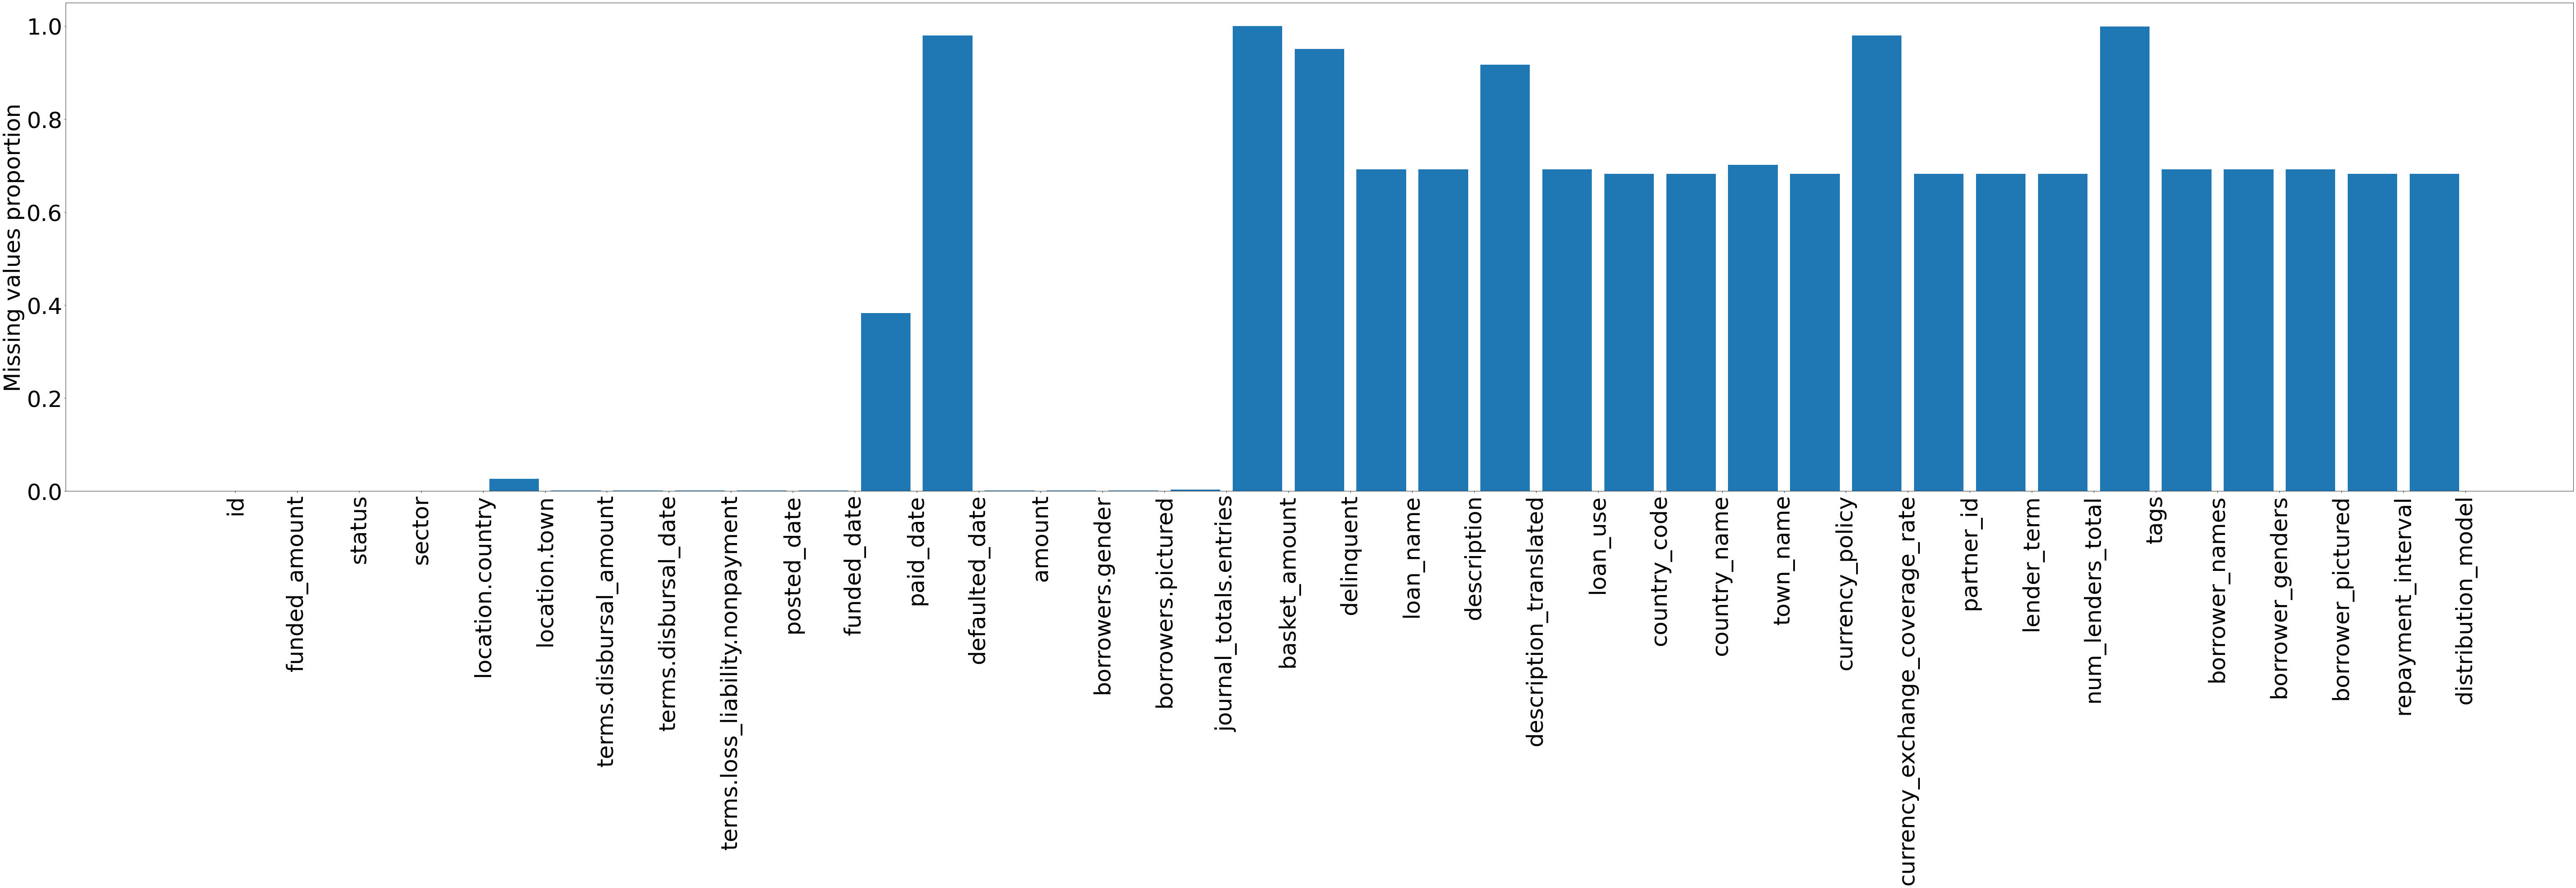

In [ ]:
## Missing values visualization
null_counts = resul.isnull().sum()/len(resul)
plt.figure(figsize=(100,20))
plt.xticks(np.arange(len(null_counts))+0.5,null_counts.index,rotation='vertical', fontsize=50)
plt.yticks(fontsize=50)
plt.ylabel('Missing values proportion', fontsize=50)
plt.bar(np.arange(len(null_counts)),null_counts)

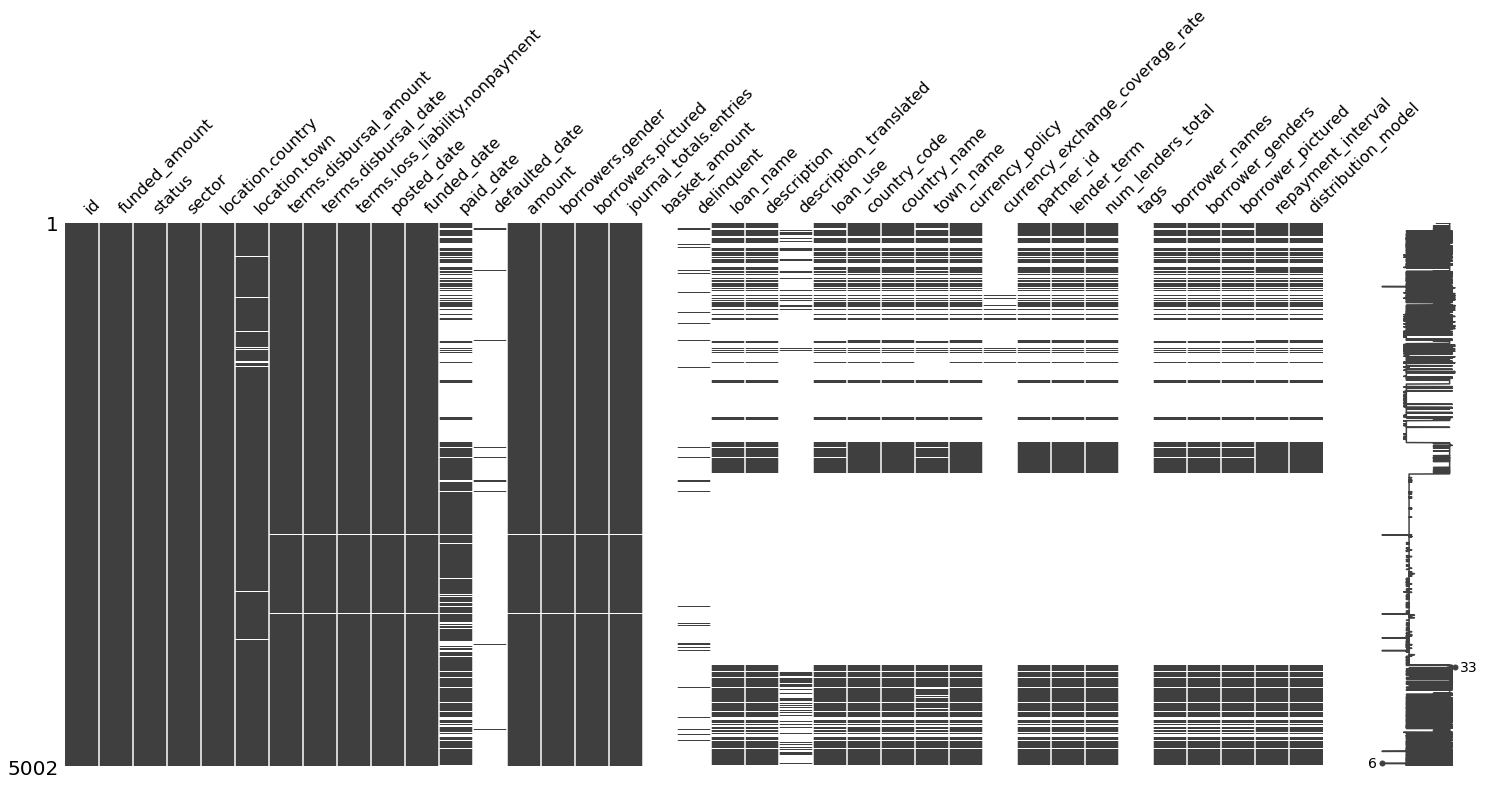

In [ ]:
msno.matrix(resul)

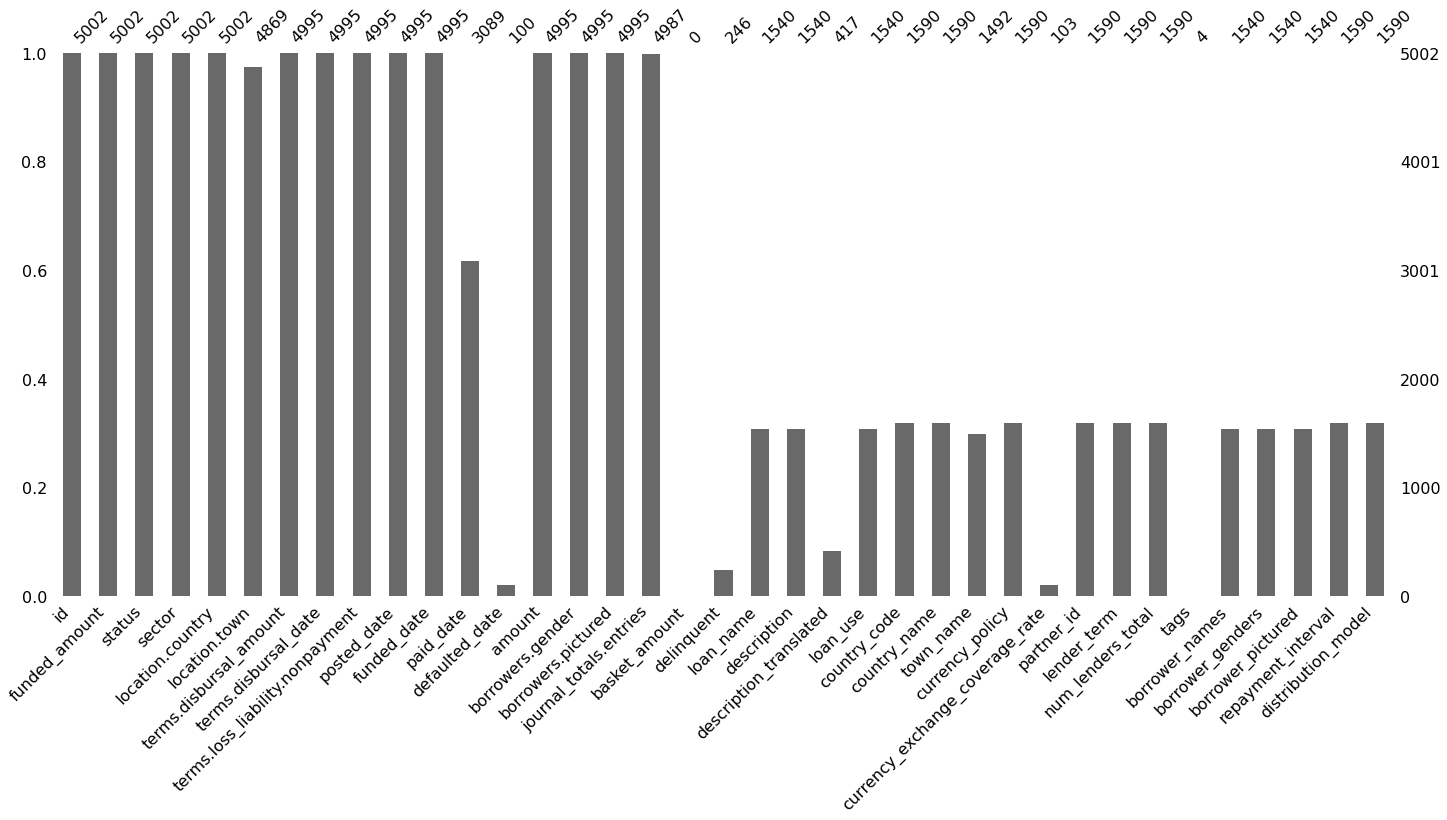

In [ ]:
msno.bar(resul)

In [22]:
pd.crosstab(resul.status,"freq")

col_0,freq
status,
defaulted,100
in_repayment,1818
paid,3084


In [23]:
# We keep only paid and defaulted observations
resul = resul[resul.status != 'in_repayment']

In [24]:
resul.status.unique()

array(['paid', 'defaulted'], dtype=object)

In [25]:
conditions = [
    (resul.status == 'defaulted'),
    (resul.status == 'paid')
]
values = [1,0]

In [26]:
resul['target'] = np.select(conditions, values)

In [27]:
pd.crosstab(resul.target,"freq")

col_0,freq
target,
0,3084
1,100


# NLP
The purpose of this part is to better understand the descriptions and uses of the loan. So, we will this algorithm for first the description variable and next the loan use. For archieving our target we are going to :
- Detect the languages of the description
- Tokens all the observation
- Delect the stop words
- Lammanize the information

In [28]:

# Looking for missing values
description = resul['loan_use'].tolist()
desc_pb = []
for myst in description:
    if isinstance(myst,float): # Les variables nan sont de type float 
        desc_pb.append(myst)

print(' Ainsi on obtient ', len(desc_pb),' valeurs manquantees.',
     "\n Etant donnée l'importance de cette variable, nous allons supprimer toutes les observations présentant des valeurs manquantes.")

 Ainsi on obtient  1644  valeurs manquantees. 
 Etant donnée l'importance de cette variable, nous allons supprimer toutes les observations présentant des valeurs manquantes.


In [29]:
resul = resul.dropna(how='all', subset=['loan_use'])

# Affichage d'une ligne de la série
resul.at[10,'loan_use']

'New refrigerator'

In [30]:
# Taille des message de description du prêt
resul['length'] = resul['loan_use'].map(len,)
#groupe suivant le statut du prêt
resul.groupby('target').length.describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,1540.0,42.486364,27.493714,4.0,25.0,38.0,51.0,491.0


As we can see only the entrepreneurs who are not in default situation pay give the use of their loan. We are going to search for the informations which are containing in this description.

In [33]:
#!pip install langdetect
from langdetect import detect

In [34]:
resul.reset_index(inplace=True)

In [35]:
# Fonction pour rechercher des éventuels erreur dans la détection de la langue de description
texte_decrip = resul['loan_use']
langdet = []                                                    

for i in range(len(resul)):                                         
    try:                                                          
       lang=detect(texte_decrip[i])                                      
    except:                                                       
       lang='no'                                                  
       print("This row throws error:", texte_decrip[i])                 
    langdet.append(lang)   

In [36]:
langdet
output = []
for x in langdet:
    if x not in output:
        output.append(x)
print(' The differents languages which are using to describe the loan are : ',output,
     '\n The number of this languages are :',len(output))

 The differents languages which are using to describe the loan are :  ['en', 'tl', 'es', 'ca', 'af', 'id', 'so', 'no', 'sv', 'fi', 'fr', 'it', 'de', 'et', 'da', 'tr', 'ro', 'pt', 'lt', 'cy', 'pl', 'nl', 'vi', 'sk'] 
 The number of this languages are : 24


In [37]:
resul['langdet'] = pd.DataFrame({'langue':langdet})
pd.crosstab(resul['langdet'],'freq').apply(lambda r: 100 * r/len(resul), axis=1).round(2)

col_0,freq
langdet,
af,0.39
ca,0.39
cy,0.06
da,0.19
de,0.52
en,89.87
es,2.99
et,0.13
fi,0.19


In [38]:
# We will have a description only for english language
database_eng = resul[['loan_use','langdet']]
database_eng = database_eng[database_eng['langdet'] == 'en']
database_eng.reset_index(inplace=True)

## Tokenisation

In [39]:
!pip install nltk

In [40]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [41]:
tokens = []
for i in range(len(database_eng)):
    tokens.append(nltk.tokenize.word_tokenize(database_eng['loan_use'][i]))
    
# Adding token variable in the dataset
database_eng['tokens'] = tokens

In [42]:
# Suppression of stops words
# uploading the corpus of english's stop-words
stop_words = set(nltk.corpus.stopwords.words('english'))
database_eng['filtered_text'] = database_eng['tokens'].map(lambda tokens: [w for w in tokens if not w in stop_words])

# Print the previous text without tokens
print(database_eng['tokens'][3],end='\n\n')
print(database_eng['filtered_text'][3],end='\n\n')
print("Mots différents :", set(database_eng['tokens'][3]) - set(database_eng['filtered_text'][3]))

['Buy', 'inventory', 'like', 'bread', ',', 'ham', ',', 'pens', 'and', 'paper', ',', 'medicine', ',', 'juices', ',', 'and', 'the', 'like', '.']

['Buy', 'inventory', 'like', 'bread', ',', 'ham', ',', 'pens', 'paper', ',', 'medicine', ',', 'juices', ',', 'like', '.']

Mots différents : {'the', 'and'}


In [43]:
wnl = nltk.WordNetLemmatizer()
database_eng['filtered_text'] = database_eng['filtered_text'].map(lambda text: wnl.lemmatize(text))

database_eng['target'] = resul['target']

TypeError: ignored

In [47]:
#!pip install Wordcount
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

In [49]:
lema = database_eng['filtered_text'].tolist()
text_lema = []
for liste in lema:
  for i in liste:
    for word in word_tokenize(i):
      text_lema.append(wnl.lemmatize(word))

In [51]:
text_lema[10]

'inventory'

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

sentence = 'missed you'
w_tokenize = (word_tokenize(sentence))

for word in w_tokenize:
  print(wnl.lemmatize(word))

In [ ]:
#!pip install Wordcloud
from wordcloud import WordCloud

In [ ]:
spam_words = ''.join(list(database_eng[database_eng['target']==0]['filtered_text']))
spam_cloud = WordCloud(width = 512,height = 512,background_color="white", collocations = True).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor ='w')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.title("Nuage des mots chez les prêt en défauts")
plt.show()

In [ ]:
msno.heatmap(resul)

In [ ]:
pd.crosstab(resul.status,"freq")

In [ ]:
resul['close_date'] = np.where(resul["defaulted_date"].isnull(), resul["paid_date"], resul["defaulted_date"] )

In [ ]:
msno.bar(resul)

In [ ]:
msno.bar(resul)

In [ ]:
pd.crosstab(resul.status,resul.delinquent)

In [ ]:
# We drop some variables with too many missing values
var_to_delete = ['basket_amount','repayment_interval','defaulted_date', 'paid_date','delinquent']
resul = resul.drop(var_to_delete, axis=1)

In [ ]:
test = resul.dropna(axis=0)
test.shape

In [ ]:
pd.crosstab(test.status,"freq")
# Only paid observations have missing values 

In [ ]:
resul = resul.dropna(axis=0)

In [ ]:
msno.bar(resul)
# we are going to work with this database

### Target variable

In [ ]:
resul.head()

In [ ]:
resul.info()

In [ ]:
resul = resul.drop('terms.disbursal_amount', axis=1)

In [ ]:
resul['funded_amount'] = pd.to_numeric(resul['funded_amount'], downcast='float')

# Categorical variables

In [ ]:
resul.sector.value_counts()

Food              951
Retail            715
Agriculture       533
Clothing          278
Services          266
Arts               94
Transportation     92
Construction       75
Manufacturing      35
Health             30
Housing            25
Wholesale          11
Personal Use        6
Education           4
Entertainment       2
Name: sector, dtype: int64

In [ ]:
categorical_var = ['sector', 'location.country','location.town', 'terms.disbursal_date',
       'terms.loss_liability.nonpayment', 'posted_date', 'funded_date','borrowers.gender', 'borrowers.pictured','close_date']
date_var = ['terms.disbursal_date','posted_date', 'funded_date','close_date']
resul[categorical_var] = resul[categorical_var].astype('category')
resul['borrowers.gender'] = resul['borrowers.gender'].cat.codes
resul['borrowers.pictured'] = resul['borrowers.pictured'].cat.codes
resul['terms.loss_liability.nonpayment'] = resul['terms.loss_liability.nonpayment'].cat.codes

In [ ]:
# We can group the sector variable
others = ['Manufecturing', 'Health', 'Housing', 'Wholesale', 'Personal Use', 'Education', 'Entertainment']
resul['sector_cat'] = np.where(resul['sector'].isin(others), "Other", resul['sector'])

In [ ]:
# We can also group the country variable
def country_to_continent(country_name):
    while True:
      try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
        break
      except KeyError:
        return 'Unknown'
    
resul['continent'] = resul['location.country'].apply(country_to_continent)

In [ ]:
#We can create dummy variables
resul = pd.get_dummies(resul, columns=['sector_cat','continent'], prefix = ['sector','continent'])
resul.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3117 entries, 0 to 5000
Data columns (total 33 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   id                               3117 non-null   object  
 1   funded_amount                    3117 non-null   float32 
 2   status                           3117 non-null   object  
 3   sector                           3117 non-null   category
 4   location.country                 3117 non-null   category
 5   location.town                    3117 non-null   category
 6   terms.disbursal_date             3117 non-null   category
 7   terms.loss_liability.nonpayment  3117 non-null   int8    
 8   posted_date                      3117 non-null   category
 9   funded_date                      3117 non-null   category
 10  amount                           3117 non-null   float64 
 11  borrowers.gender                 3117 non-null   int8    
 12  borrow

In [ ]:
resul

,id,funded_amount,status,sector,location.country,location.town,terms.disbursal_date,terms.loss_liability.nonpayment,posted_date,funded_date,amount,borrowers.gender,borrowers.pictured,journal_totals.entries,close_date,target,sector_Agriculture,sector_Arts,sector_Clothing,sector_Construction,sector_Food,sector_Manufacturing,sector_Other,sector_Retail,sector_Services,sector_Transportation,continent_Africa,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,continent_Unknown
0,156,500.0,paid,Construction,Nicaragua,Managua,14/04/2005,1,15/02/2006,31/03/2005,50.00,1,0,1.0,16/09/2006,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,173,600.0,defaulted,Construction,Gaza,Rafah,14/04/2005,0,15/02/2006,31/03/2005,50.00,1,0,7.0,11/09/2007,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,183,500.0,paid,Food,Honduras,Siguatepeque,14/04/2005,1,15/03/2006,31/03/2005,35.00,0,0,2.0,21/11/2006,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
4,200,575.0,paid,Services,Kenya,Ongata Rongai,14/04/2005,1,15/03/2006,31/03/2005,114.00,0,0,2.0,02/05/2007,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
5,213,225.0,paid,Food,Honduras,Danli,14/04/2005,1,15/03/2006,31/03/2005,40.00,1,0,1.0,28/11/2006,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,102400,150.0,paid,Retail,Philippines,Purok 9b Kiwalan. Iligan City,15/04/2009,1,17/04/2009,17/04/2009,7.89,0,0,2.0,15/09/2009,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4995,102453,350.0,paid,Food,Nigeria,Lagos State,01/04/2009,1,17/04/2009,17/04/2009,43.75,0,0,1.0,15/12/2009,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4998,102713,225.0,paid,Agriculture,Philippines,Cebulin. Plaridel. Misamis Occidental,20/03/2009,1,18/04/2009,18/04/2009,28.12,0,0,2.0,15/09/2009,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4999,102744,75.0,paid,Clothing,Philippines,Bacolod. Ozamiz City. Mis. Occ.,31/03/2009,1,18/04/2009,18/04/2009,12.05,0,0,2.0,16/10/2009,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


# Prediction model

## re-sampling

As we saw in statistic of the target variable, we only have 100 defaulted observation,
that is while we are going to re-sample the dataset to have at list the same number of
inrepayment and default.

In [ ]:
resul.target.unique()

array([0, 1])

In [ ]:
data_def = resul.loc[resul.target==1]
data_rep = resul.loc[resul.target==0]
print('Base repayment : ', data_rep.shape,'\nBase default : ',data_def.shape)

Base repayment :  (3017, 33) 
Base default :  (100, 33)


In [ ]:
data_rep = data_rep.sample(n=100, replace = False)

In [ ]:
final = data_def.append(data_rep)

In [ ]:
pd.crosstab(final.target,'y')

col_0,y
target,
0,100
1,100


# Modelisation

In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.discrete.discrete_model import Probit
from statsmodels.api import Logit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
Y = final['target']
X = final.drop(['id','target','status','location.town','location.country','sector', 'sector_Agriculture', 'continent_Africa'], axis=1)
X = X.drop(date_var, axis=1)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,random_state=0)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(150, 21)
(50, 21)


In [ ]:
## Confusion matrix 
logreg = LogisticRegression()
logreg.fit(X_train,Y_train)
Y_pred=logreg.predict(X_test)
cnf_matrix = metrics.confusion_matrix(Y_test,Y_pred)
cnf_matrix

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


array([[26,  1],
       [ 4, 19]])

Text(0.5, 257.44, 'Predicted label')

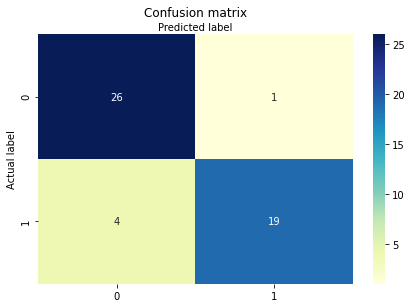

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print("Accuracy:",metrics.accuracy_score(Y_test,Y_pred))
print("Precision:",metrics.precision_score(Y_test,Y_pred))
print("Recall:",metrics.recall_score(Y_test,Y_pred))

Accuracy: 0.9
Precision: 0.95
Recall: 0.8260869565217391


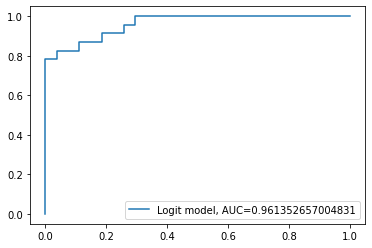

In [ ]:
# ROC Curve
Y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  Y_pred_proba)
auc = metrics.roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr,tpr,label="Logit model, AUC="+str(auc))
plt.legend(loc=4)
plt.show()

# Statistique Descriptive

In [ ]:
data_loan.describe()

NameError: ignored

In [ ]:
label_counts = data_loan['borrowers.gender'].value_counts()
plt.figure(figsize = (4,5))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('Gender', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

In [ ]:
data_loan.groupby('target').funded_amount.describe()

In [ ]:
data_loan.groupby('target').paid_amount.describe()

In [ ]:
data_loan.groupby('target').amount.describe()

In [ ]:
plt.rcParams['figure.figsize'] = (10, 7)
sns.boxenplot(x = data_loan['target'], y = data_loan['amount'])
plt.title('Relation between target and amount', fontsize = 20)
plt.show()

In [ ]:
data_loan.funded_amount.hist(bins = 20)

In [ ]:
from sklearn import preprocessing

In [ ]:
scaler = preprocessing.Normalizer().fit(data_loan['funded_amount'].dropna(how = "any").head(1000))
X1 = scaler.transform(data_loan['funded_amount'].dropna(how = "any").head(1000))
